# Mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ladi-vton

Mounted at /content/drive
/content/drive/MyDrive/ladi-vton


# Installing

In [2]:
!pip install torch==2.0.1 torchvision==0.15.2 opencv-python==4.7.0.72 diffusers==0.14.0 transformers==4.27.3 accelerate==0.18.0 clean-fid==0.1.35 torchmetrics[image]==0.11.4 wandb==0.14.0 matplotlib==3.7.1 tqdm xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

*This Result needs to be TRUE*

In [3]:
import torch
torch.cuda.is_available()

True

# Preprocess

In [4]:
#Clear
import os
import glob
import shutil
from PIL import Image

files = glob.glob('input/*/*/*.*')
for f in files:
  os.remove(f)

files = glob.glob('results/*/*/*.*')
for f in files:
  os.remove(f)

def resize_with_pad(im, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)

    image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

#Add pairs
def write_row(file_, *columns):
    print(*columns, sep='\t', end='\n', file=file_)

upper = open('input/upper_body/test_pairs_unpaired.txt', 'w')
lower = open('input/lower_body/test_pairs_unpaired.txt', 'w')
dresses = open('input/dresses/test_pairs_unpaired.txt', 'w')
all = open('input/test_pairs_paired.txt', 'w')

with open('images/test_pairs.txt', "r") as file:
    data = file.readlines()
    for line in data:
        word = line.split()
        org_path = 'images/humans/' + word[0]
        if(word[2] == '0'):
          write_row(upper,'0'+word[0],word[1])
          write_row(all,'0'+word[0],word[1],word[2])
          res_path = 'input/upper_body/images/0' + word[0]
        elif(word[2] == '1'):
          write_row(lower,'1'+word[0],word[1])
          write_row(all,'1'+word[0],word[1],word[2])
          res_path = 'input/lower_body/images/1' + word[0]
        elif(word[2] == '2'):
          write_row(dresses,'2'+word[0],word[1])
          write_row(all,'2'+word[0],word[1],word[2])
          res_path = 'input/dresses/images/2' + word[0]
        image = Image.open(org_path)
        new = resize_with_pad(image,384,512)
        new.save(res_path)

upper.close()
lower.close()
dresses.close()
all.close()

%cd preprocess
!git clone https://github.com/Hzzone/pytorch-openpose.git
%cd pytorch-openpose

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import copy
import numpy as np
import glob
import json
import os

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')
for s in ['upper_body','lower_body','dresses']:
  input_path = '/content/drive/MyDrive/ladi-vton/input/' + s + '/images/'
  output_path = '/content/drive/MyDrive/ladi-vton/input/'+ s + '/skeletons/'
  keypoint_path = '/content/drive/MyDrive/ladi-vton/input/'+ s + '/keypoints/'


  for images in glob.glob('*',root_dir = input_path):
      oriImg = cv2.imread(input_path+images)  # B,G,R order
      candidate, subset = body_estimation(oriImg)
      canvas = util.draw_bodypose(np.zeros_like(oriImg), candidate, subset)
      arr = candidate.tolist()
      vals = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
      for i in range(0,18):
        if len(arr)==i or arr[i][3] != vals[i]:
          arr.insert(i,[-1,-1,-1,vals[i]])

      keypoints = {'keypoints':arr[:18]}
      cv2.imwrite(output_path + images.replace('_0','_5'),canvas)
      with open(keypoint_path+ os.path.splitext(images)[0].replace('_0','_2') +".json" , 'w') as fin:
        fin.write(json.dumps(keypoints))


%cd ../..

%cd preprocess
!pip install ninja
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing

!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/ladi-vton/input/upper_body/images/' --output-dir '/content/drive/MyDrive/ladi-vton/input/upper_body/label_maps/'

!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/ladi-vton/input/lower_body/images/' --output-dir '/content/drive/MyDrive/ladi-vton/input/lower_body/label_maps/'

!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/ladi-vton/input/dresses/images/' --output-dir '/content/drive/MyDrive/ladi-vton/input/dresses/label_maps/'


%cd ../..

%cd preprocess

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

%cd detectron2/projects/DensePose
!pip install av
!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/upper_body/images dp_segm -v --output /content/drive/MyDrive/ladi-vton/input/upper_body/dense/

!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/lower_body/images dp_segm -v  --output /content/drive/MyDrive/ladi-vton/input/lower_body/dense/

!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/dresses/images dp_segm -v   --output /content/drive/MyDrive/ladi-vton/input/dresses/dense/

!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/upper_body/images -v --output /content/drive/MyDrive/ladi-vton/input/upper_body/dense/

!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/lower_body/images -v --output /content/drive/MyDrive/ladi-vton/input/lower_body/dense/

!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/dresses/images -v --output /content/drive/MyDrive/ladi-vton/input/dresses/dense/

%cd ../../../..

from google.colab.patches import cv2_imshow
import cv2
import glob
pattern = 'input/*/dense/*'
mp ={0: 0, 128: 18, 64: 4, 132: 19, 69: 5, 136: 20, 75: 6, 140: 21, 145: 22, 85: 9, 150: 23, 90: 10, 155: 24, 121: 16, 105: 13, 111: 14, 52: 2, 117: 15, 57: 3, 124: 17,
     2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 9: 9, 10: 10, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24}

lut = np.zeros((256, 1), dtype=np.uint8)

for i in range(0,256):
    lut[i] = mp.get(i) or mp[min(mp.keys(), key = lambda key: abs(key-i))]

for images in glob.glob(pattern):
    if images.endswith(".png"):
      image = cv2.imread(images,cv2.IMREAD_GRAYSCALE)
      cv2.imwrite(images,cv2.LUT(image,lut))

#Clear
import os
import glob
import shutil
from PIL import Image

files = glob.glob('input/*/*/*.*')
for f in files:
  if f.endswith("_1.jpg") or f.endswith("_1.png"):
    os.remove(f)

def resize_with_pad(im, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)

    image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

for c in ['dresses','upper_body','lower_body']:
  files = glob.glob('images/'+c+'/*.*')
  path = 'input/' + c + '/images/'
  for f in files:
    if f.endswith("_1.jpg"):
      res = path +os.path.basename(f)
      shutil.copy (f, res)
      image = Image.open(res)
      new = resize_with_pad(image,384,512)
      new.save(res)

<ipython-input-4-d85568672b11>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)


/content/drive/MyDrive/ladi-vton/preprocess
fatal: destination path 'pytorch-openpose' already exists and is not an empty directory.
/content/drive/MyDrive/ladi-vton/preprocess/pytorch-openpose
/content/drive/MyDrive/ladi-vton
/content/drive/MyDrive/ladi-vton/preprocess
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 4.9 MB/s eta 0:00:00
fatal: destination path 'Self-Correction-Human-Parsing' already exists and is not an empty directory.
/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing
Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 1/1 [00:00<00:00,  1.04it/s]
Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-ar

<ipython-input-4-d85568672b11>:226: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)


## Cloth Mask

In [5]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import copy
import glob
import json
import os

def otsu(img , n  , x ):
    img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(img_gray,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,n,x)
    return thresh

def contour(img):
    edges = cv2.dilate(cv2.Canny(img,200,255),None)
    cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    masked = cv2.drawContours(mask, [cnt],-1, 255, -1)
    return masked

def get_cloth_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(image)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
    return mask

def write_edge(C_path,E_path):
    img = cv2.imread(C_path)
    res = get_cloth_mask(img)
    if(np.mean(res)<100):
        ot = otsu(img,11,0.6)
        res = contour(ot)
    cv2.imwrite(E_path,res)

for s in ['upper_body','lower_body','dresses']:
  input_path = '/content/drive/MyDrive/ladi-vton/input/' + s + '/images/'
  output_path = '/content/drive/MyDrive/ladi-vton/input/'+ s + '/masks/'
  for images in glob.glob('*',root_dir = input_path):
      if images.endswith("_1.jpg"):
        write_edge(input_path + images , output_path+ os.path.splitext(images)[0] +".png")

# Testing

In [6]:
import gc
gc.collect()

16

In [7]:
!sh test.sh

2023-12-10 08:31:53.723744: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 08:31:53.723806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 08:31:53.723850: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 08:31:56.011249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
scheduler/scheduler_config.json: 100% 308/308 [00:00<00:00, 1.66MB/s]
text_encoder/config.json: 100% 638/638 [00:00<00:00, 2.72MB/s]
model.safetensors: 100% 1.36G/1.36G [00:08<00:00, 151MB/s]
diffusion_pytorch_model.safetensors: 100% 335M

In [8]:
# !sh metrics.sh

#Results DressCode

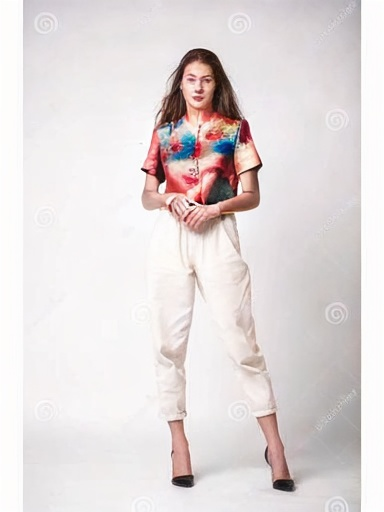

In [9]:
from google.colab.patches import cv2_imshow
import cv2
import glob

pattern = 'results/unpaired/*/*'
for images in glob.glob(pattern):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
      cv2_imshow(cv2.imread(images, cv2.IMREAD_UNCHANGED))

#Results VITON HD

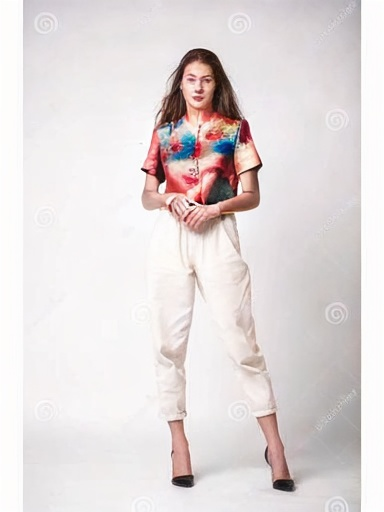

In [10]:
from google.colab.patches import cv2_imshow
import cv2
import glob

pattern = 'results/unpaired/*/*'
for images in glob.glob(pattern):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
      cv2_imshow(cv2.imread(images, cv2.IMREAD_UNCHANGED))